<a href="https://colab.research.google.com/github/Vakurin/GANs-On-TensorFlow-2/blob/master/GAN_FirstModel_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline
* Import Libraries


## Import libraries 
---

In [1]:
# Make default version tf2.0 in colab
%tensorflow_version 2.x 

import tensorflow as tf
print(tf.__version__)
keras = tf.keras

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

TensorFlow 2.x selected.
2.1.0


## Global Variables - parameters of images and noise vector Z

In [0]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

# Size of noise vector, we used it for input Generator 
z_dim = 100 

# This noisy vector we push into NN and generate new image  

## Build Generator
Generator takes a noisy vector and create images.

**What need to focused on**
* Input_Dim - noisy vector Z 
* LeakyRelu - for little negative gradient
* Activation 'tanh' - it's makes more clearly images
* Reshape our neurons on image we need 
* Before reshape makes neurons by multiplie


In [0]:
def model_generator(img_shape, z_dim):
  model = keras.models.Sequential(name='Generator')

  model.add(keras.layers.Dense(128, input_dim=z_dim))
  
  # We used leakyRelu for activation function, it's makes a small negative gradient
  model.add(keras.layers.LeakyReLU(alpha=0.01))
  
  # We used tanh which scale output values to the range [-1, 1]
  # Tanh makes images more clearly  
  # 28 x 28 x 1
  model.add(keras.layers.Dense(img_shape[0] * img_shape[1] * img_shape[2], activation='tanh'))

  # Reshape Generator Output To Image Demensions
  model.add(keras.layers.Reshape(img_shape, name='Generator_Output'))

  return model

In [4]:
model_generator(img_shape, z_dim).summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               101136    
_________________________________________________________________
Generator_Output (Reshape)   (None, 28, 28, 1)         0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


## Build Discriminator
Take a image and outputs a probability indicating real or fake image.

**What need to focused on:**
* Last Layer Activation 'sigmoid'


In [0]:
def model_discriminator(img_shape):
  model = keras.Sequential(name='Discriminator')
  # Turn Image Into Vector 
  model.add(keras.layers.Flatten(input_shape=img_shape))

  model.add(keras.layers.Dense(128))

  model.add(keras.layers.LeakyReLU(alpha=0.01))
  # Prediction Layer Fake or Not 
  model.add(keras.layers.Dense(1, activation='sigmoid', name='Discriminator_Output'))

  return model

In [6]:
model_discriminator(img_shape).summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
Discriminator_Output (Dense) (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


## Build and Complie Gan
* D is trained as an independently compile model 
* Combine model used to train G, we keep the D parameters fixed by training=False


In [0]:
def build_gan(generator, discriminator):
  model = keras.Sequential(name='GAN')

  model.add(generator)
  model.add(discriminator)

  return model

In [0]:
discriminator = model_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'])

generator = model_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', 
            optimizer=keras.optimizers.Adam())

In [9]:
gan.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 28, 28, 1)         114064    
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 100609    
Total params: 214,673
Trainable params: 114,064
Non-trainable params: 100,609
_________________________________________________________________


## Training Models

### Display Output Image

In [0]:
def sample_images(generator, iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    # Iteration Print 
    fig.suptitle('Iteration ' + str(iteration), fontsize="x-large")
    
    for i in range(image_grid_rows):    
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            
            
            cnt += 1

### Training
**What need to focus?**

* Grayscale pixel values between [-1, 1] 

```
X_train / 127.5 - 1.0
```
* Make Real(1) And Fake(0) Labels With Batch Size

```
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
```
---
### Training Discriminator 
Step By Step
* Get Random Numbers Of Real Images
* Generated Fake Images
* Equal Real Images With Real Labels and Fake Image With Fake Labels Make Two Batch
* Train On Batch 
---
### Training Generator
* Make A Random Vector And Predict 
* Train On Batch 




In [0]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = keras.datasets.mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            iter_print = (iteration + 1) // 1000
            # Output a sample of generated image
            sample_images(generator, iter_print)

1000 [D loss: 0.421111, acc.: 80.08%] [G loss: 3.437337]
2000 [D loss: 0.368997, acc.: 84.38%] [G loss: 3.135574]
3000 [D loss: 0.466054, acc.: 79.69%] [G loss: 3.245746]
4000 [D loss: 0.653106, acc.: 71.88%] [G loss: 2.218589]
5000 [D loss: 0.347400, acc.: 85.16%] [G loss: 2.997384]
6000 [D loss: 0.487534, acc.: 76.17%] [G loss: 2.360984]
7000 [D loss: 0.485980, acc.: 77.34%] [G loss: 2.458474]
8000 [D loss: 0.398039, acc.: 80.08%] [G loss: 2.449187]
9000 [D loss: 0.364917, acc.: 84.38%] [G loss: 2.511911]
10000 [D loss: 0.475753, acc.: 79.30%] [G loss: 2.482790]
11000 [D loss: 0.360337, acc.: 82.03%] [G loss: 3.037759]
12000 [D loss: 0.402994, acc.: 81.25%] [G loss: 2.308456]
13000 [D loss: 0.406610, acc.: 80.47%] [G loss: 2.309274]
14000 [D loss: 0.326936, acc.: 86.33%] [G loss: 2.511827]
15000 [D loss: 0.292662, acc.: 83.59%] [G loss: 2.910761]
16000 [D loss: 0.509959, acc.: 73.83%] [G loss: 2.078936]
17000 [D loss: 0.313059, acc.: 86.72%] [G loss: 2.357499]
18000 [D loss: 0.313832

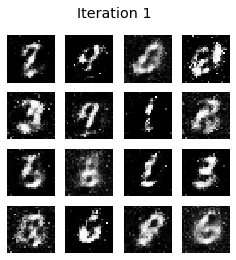

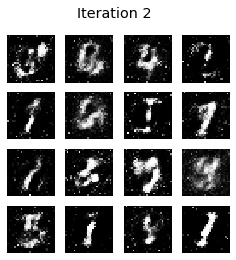

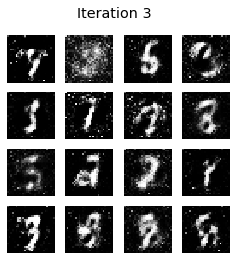

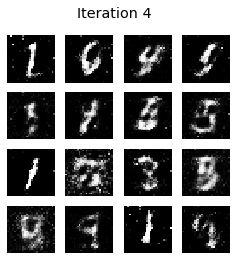

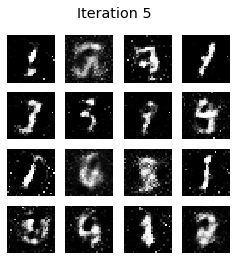

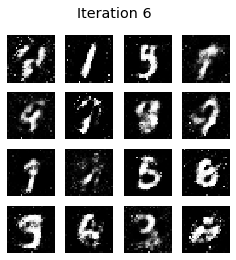

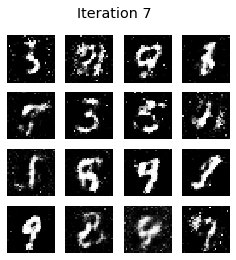

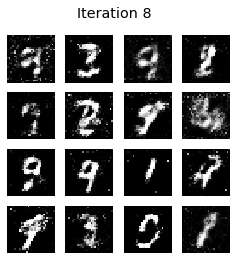

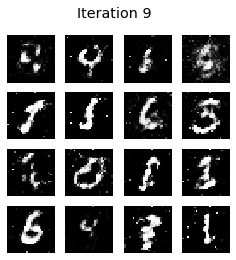

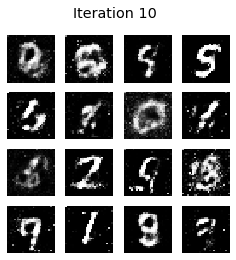

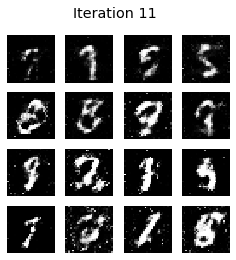

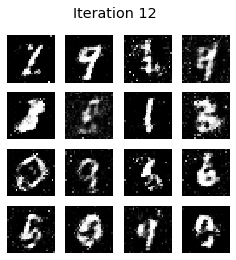

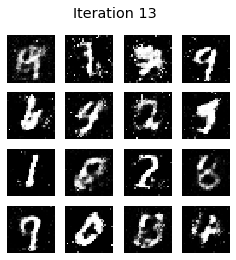

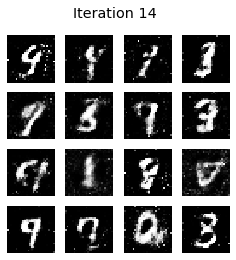

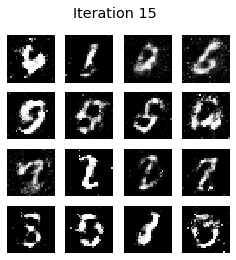

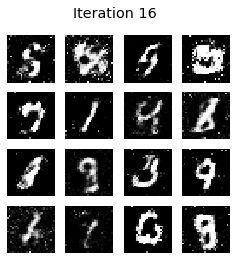

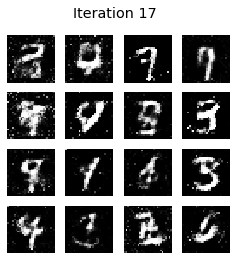

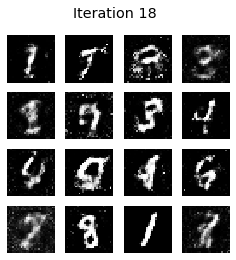

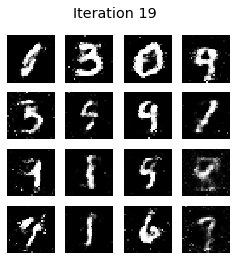

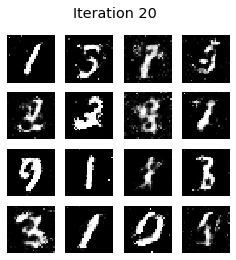

In [39]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

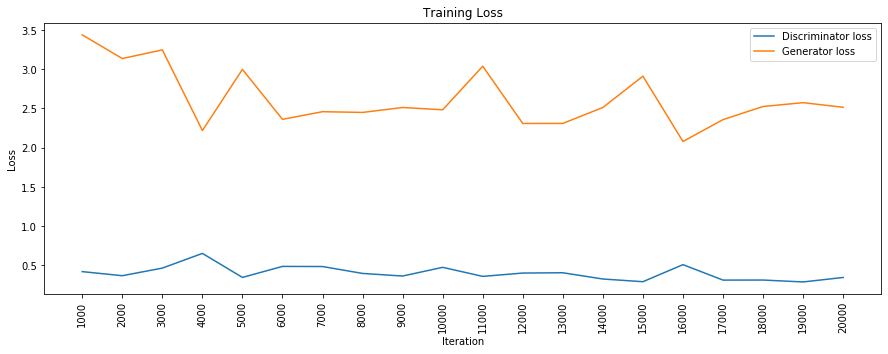

In [43]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend();

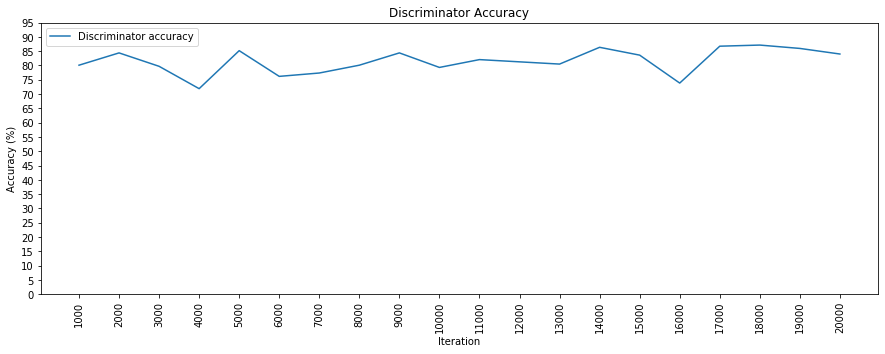

In [42]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend();